# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.2 MB/s eta 0:00:48tcmalloc: large alloc 1147494400 bytes == 0x648b2000 @  0x7f4d8083e615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 890.2 MB 6.9 kB/s 
     |████████████████████████████████| 24.3 MB 1.4 MB/s 
     |████████████████████████████████| 849 kB 53.3 MB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 317.1 MB 27 kB/s 
     |████████████████████████████████| 557.1 MB 12 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully unin

In [ ]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [35]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

Found existing installation: Pillow 7.1.2
Uninstalling Pillow-7.1.2:
  Successfully uninstalled Pillow-7.1.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 12.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.10 requires pillow>6.0.0, but you have pillow 5.3.0 which is incompatible.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.


7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!ls /content/gdrive/

MyDrive  Shareddrives


In [3]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Nov 12 12:29 /content/gdrive/MyDrive/journey-springfield.zip


In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [5]:
!ls -1

characters_illustration.png
gdrive
sample_data
sample_submission.csv
testset
train


In [6]:
!ls train
!ls testset

simpsons_dataset
testset


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Nov 16 20:04:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8     8W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [8]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [9]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

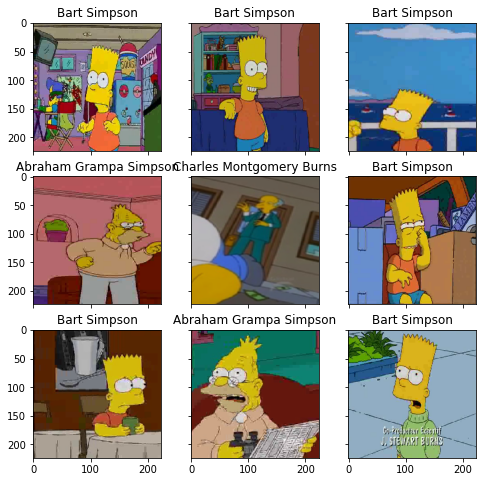

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [15]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [16]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

NameError: ignored

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.5518086751302085


epoch:  50%|█████     | 1/2 [02:35<02:35, 155.89s/it]


Epoch 001 train_loss: 2.5518     val_loss 1.9290 train_acc 0.2878 val_acc 0.4866
loss 1.553069792717792


epoch: 100%|██████████| 2/2 [05:05<00:00, 152.67s/it]


Epoch 002 train_loss: 1.5531     val_loss 1.3380 train_acc 0.5778 val_acc 0.6429


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

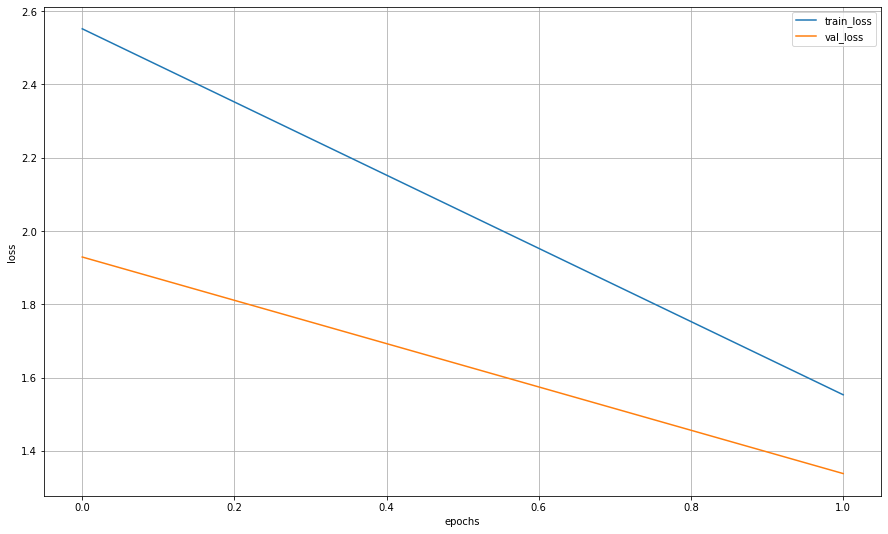

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(True)
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [36]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)


array([0.88888889, 0.        , 0.88888889, 0.        , 0.        ,
       0.33333333, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

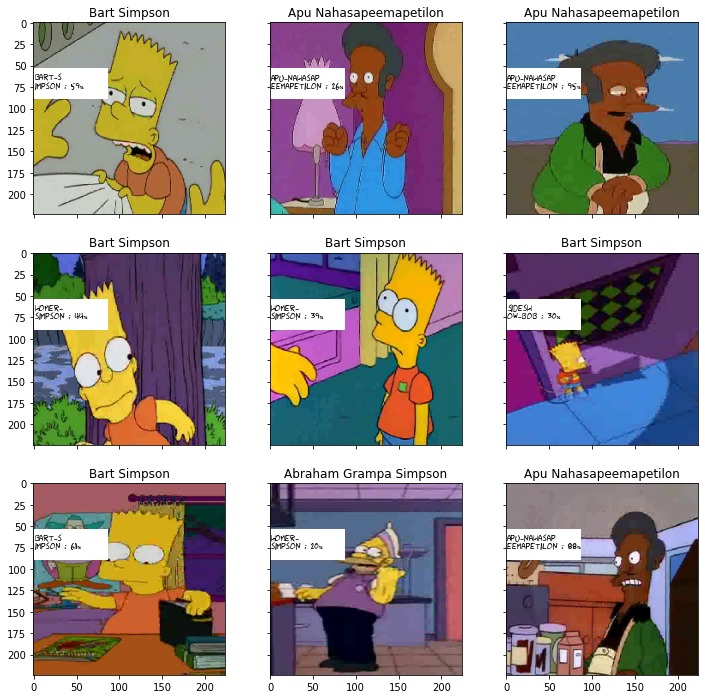

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


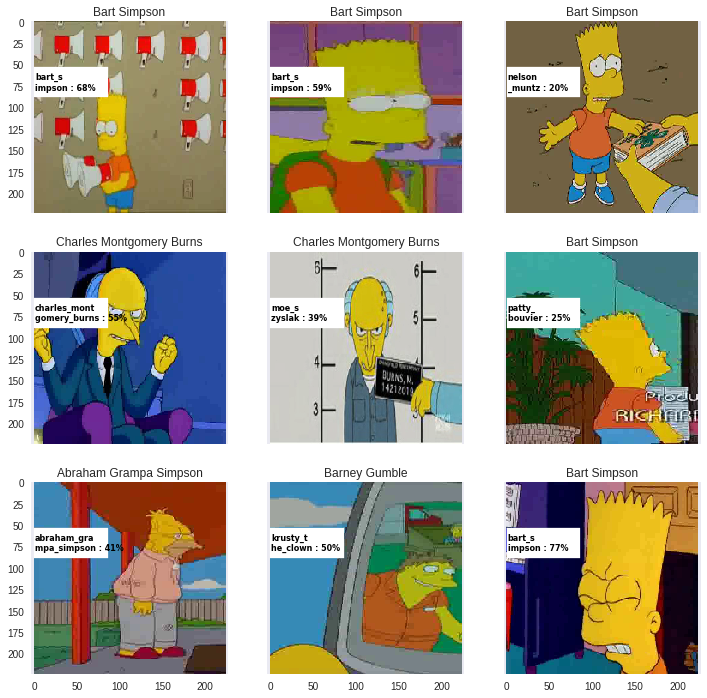

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/MyDrive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('gdrive/MyDrive/simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# Предобработка данных

Добавим аугментацию данных

In [70]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform1 = transforms.Compose([
            #transforms.Pad(),
            #transforms.RandomCrop(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomAffine(15),
            #transforms.RandomInvert(),
            transforms.ColorJitter(brightness=0.3),
            transforms.RandomHorizontalFlip(p=0.5),
        ])
        transform2 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            x = transform1(x)
        x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        x = transform2(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [71]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [72]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Размножим классы с маленьким числом картинок.

Соберем все ссылки по валидациии и трейну

In [73]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

Разобьем трейн в словарь класс - ссылки данного класса.

In [74]:
from collections import defaultdict
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = defaultdict(list)
    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [75]:
dct_path_train = create_dct_path_labels(train_files, train_labels)
print_dct(dct_path_train)

marge_simpson	[PosixPath('train/simpsons_dataset/marge_simpson/pic_1117.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_1040.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0639.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0782.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0542.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_1289.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0624.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0402.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0587.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0343.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0209.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0864.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0960.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0611.jpg'), PosixPath('train/simpsons_dataset/marge_simpson/pic_0745.jpg'), PosixPath('train/simpsons

Все классы, в которых меньше 100 ссылок добавим те же ссылки до 100. Из-за аугментации это будут немного разные картинки на обучении. 

In [76]:
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [77]:
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

marge_simpson	968
mayor_quimby	185
rainier_wolfcastle	100
homer_simpson	1684
charles_montgomery_burns	895
lisa_simpson	1015
moe_szyslak	1089
milhouse_van_houten	809
sideshow_bob	658
krusty_the_clown	904
ned_flanders	1090
nelson_muntz	269
bart_simpson	1006
abraham_grampa_simpson	685
maggie_simpson	100
kent_brockman	373
groundskeeper_willie	100
principal_skinner	895
apu_nahasapeemapetilon	467
agnes_skinner	100
chief_wiggum	739
lenny_leonard	233
comic_book_guy	352
edna_krabappel	343
otto_mann	100
selma_bouvier	100
professor_john_frink	100
waylon_smithers	136
ralph_wiggum	100
carl_carlson	100
cletus_spuckler	100
snake_jailbird	100
barney_gumble	100
sideshow_mel	100
patty_bouvier	100
martin_prince	100
fat_tony	100
gil	100
troy_mcclure	100
lionel_hutz	100
miss_hoover	100
disco_stu	100


Соберем обратно все трейн файлы.

In [78]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

Создадим датасеты.

In [79]:
val_dataset = SimpsonsDataset(val_files, mode='val')    
train_dataset = SimpsonsDataset(new_train_files, mode='train')

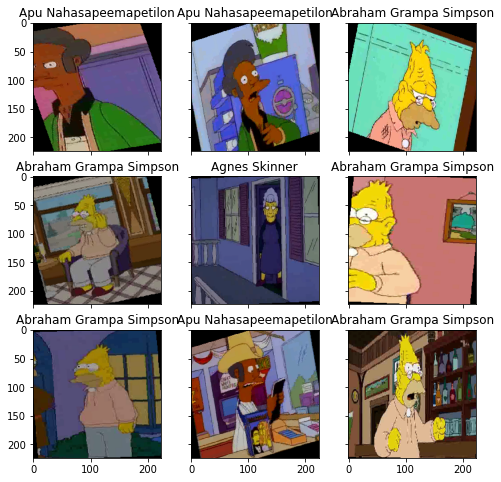

In [80]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Модели

# VGG


In [28]:
from torchvision import models

In [ ]:
vgg = models.vgg16_bn(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Заморозим первые слои. Разморожены будут последний 21 слой сверток и полносвязная часть.

In [ ]:
layers_to_unfreeze = 21

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in vgg.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

num_features = 25088
n_classes = len(np.unique(train_val_labels))

vgg.classifier = nn.Sequential(
     nn.Linear(in_features=num_features, out_features=4096, bias=True),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5, inplace=False),
     nn.Linear(in_features=4096, out_features=4096, bias=True),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5, inplace=False),
     nn.Linear(in_features=4096, out_features=n_classes, bias=True),
)

vgg = vgg.cuda()

In [39]:
import torch.optim as optim
from torch.optim import lr_scheduler

Обучение. Со своим оптимизатором.

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optim.Adam(list(vgg.features.parameters())[-layers_to_unfreeze:])
        scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            scheduler.step()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
history = train(train_dataset, val_dataset, model=vgg, epochs=2, batch_size=16)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.829219280621741


epoch:  50%|█████     | 1/2 [05:56<05:56, 356.91s/it]


Epoch 001 train_loss: 2.8292     val_loss 1.6689 train_acc 0.3172 val_acc 0.6458
loss 0.8616254464719759


epoch: 100%|██████████| 2/2 [11:42<00:00, 351.22s/it]


Epoch 002 train_loss: 0.8616     val_loss 0.5068 train_acc 0.7862 val_acc 0.8687


Сохраним полученные веса.

In [ ]:
torch.save(vgg.state_dict(), "/content/gdrive/MyDrive/vgg2epochs_weights.pth") 

In [ ]:
vgg.load_state_dict(torch.load('/content/gdrive/MyDrive/vgg2epochs_weights.pth'))

<All keys matched successfully>

Еще 2 эпохи

In [ ]:
history = train(train_dataset, val_dataset, model=vgg, epochs=2, batch_size=16)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.3972740772868592


epoch:  50%|█████     | 1/2 [05:34<05:34, 334.86s/it]


Epoch 001 train_loss: 0.3973     val_loss 0.4217 train_acc 0.8996 val_acc 0.8953
loss 0.28122057078958634


epoch: 100%|██████████| 2/2 [11:09<00:00, 334.51s/it]


Epoch 002 train_loss: 0.2812     val_loss 0.3281 train_acc 0.9273 val_acc 0.9186


In [ ]:
torch.save(vgg.state_dict(), "/content/gdrive/MyDrive/vgg4epochs_weights.pth") 

In [ ]:
vgg.load_state_dict(torch.load('/content/gdrive/MyDrive/vgg4epochs_weights.pth'))

<All keys matched successfully>

Результаты

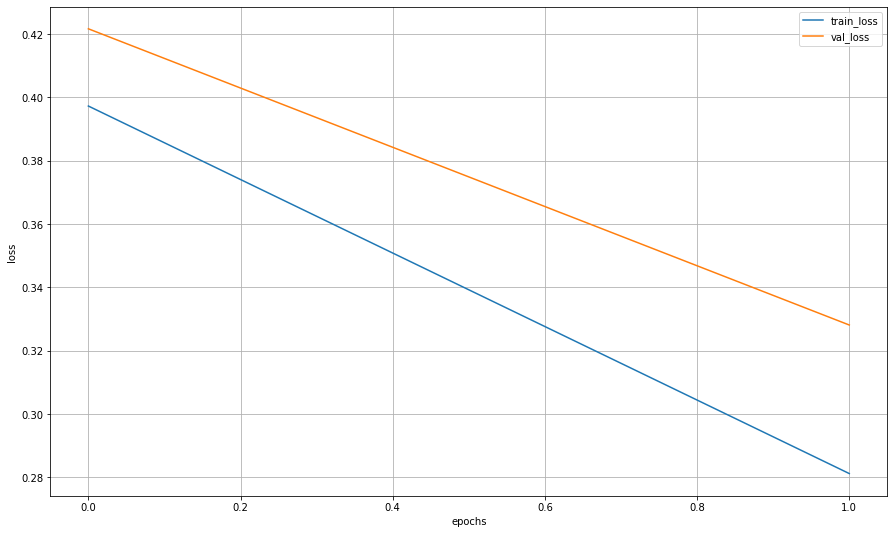

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(True)
plt.show()

In [34]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(vgg, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(vgg, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)


array([1.        , 0.        , 0.85714286, 1.        , 0.94117647,
       0.8       , 0.        , 0.        ])

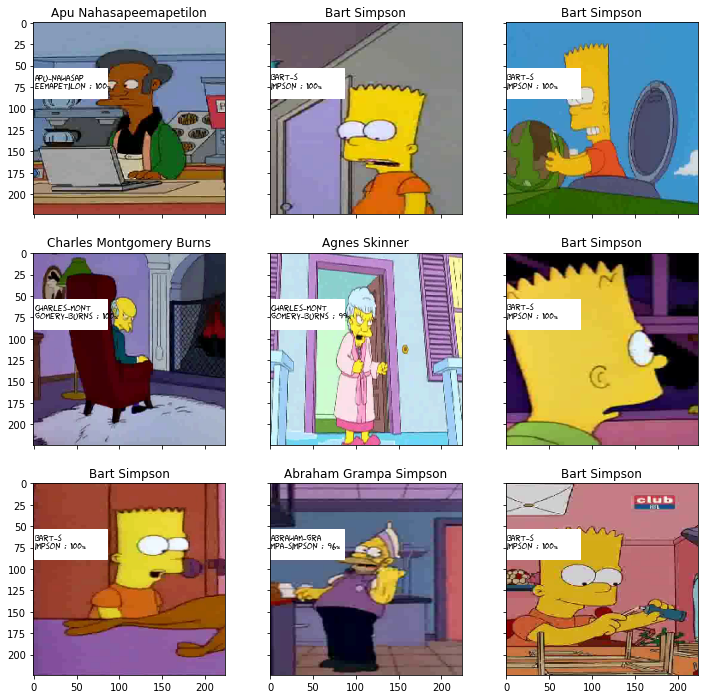

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(vgg, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Загрузим результаты теста.

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(vgg, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/MyDrive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
my_submit.to_csv('gdrive/MyDrive/vgg3.csv', index=False)

# Resnet


In [ ]:
resnet = models.resnet101(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet.fc = nn.Linear(2048, n_classes)

In [ ]:
resnet = resnet.cuda()

Заморозим первые 3 блока из 4.

In [ ]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet.layer1.parameters():
    param.requires_grad = False
for param in resnet.layer2.parameters():
    param.requires_grad = False
for param in resnet.layer3.parameters():
    param.requires_grad = False

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optim.Adam(list(model.layer4.parameters()) + list(model.avgpool.parameters()) + list(model.fc.parameters()))
        scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            scheduler.step()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
history = train(train_dataset, val_dataset, model=resnet, epochs=2, batch_size=16)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss 0.7932376276365443


epoch:  50%|█████     | 1/2 [06:25<06:25, 385.70s/it]


Epoch 001 train_loss: 0.7932     val_loss 0.3860 train_acc 0.8004 val_acc 0.9070
loss 0.5139305833530435


epoch: 100%|██████████| 2/2 [12:36<00:00, 378.50s/it]


Epoch 002 train_loss: 0.5139     val_loss 0.3328 train_acc 0.8694 val_acc 0.9182


In [ ]:
torch.save(resnet.state_dict(), "/content/gdrive/MyDrive/resnet2epochs_weights.pth") 

In [ ]:
resnet.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet2epochs_weights.pth'))

Еще эпоха.

In [ ]:
history = train(train_dataset, val_dataset, model=resnet, epochs=1, batch_size=16)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

loss 0.28188103196791997


epoch: 100%|██████████| 1/1 [06:32<00:00, 392.34s/it]


Epoch 001 train_loss: 0.2819     val_loss 0.2594 train_acc 0.9299 val_acc 0.9377


In [ ]:
torch.save(resnet.state_dict(), "/content/gdrive/MyDrive/resnet3epochs_weights.pth") 

In [ ]:
resnet.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet3epochs_weights.pth'))

И еще эпоха

In [ ]:
train(train_dataset, val_dataset, model=resnet, epochs=1, batch_size=16)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss 0.19524774889529495


epoch: 100%|██████████| 1/1 [06:18<00:00, 378.38s/it]


Epoch 001 train_loss: 0.1952     val_loss 0.2309 train_acc 0.9491 val_acc 0.9469


[(0.19524774889529495,
  0.9491050385374865,
  0.23092805883379297,
  tensor(0.9469, device='cuda:0', dtype=torch.float64))]

In [ ]:
torch.save(resnet.state_dict(), "/content/gdrive/MyDrive/resnet4epochs_weights.pth")

In [ ]:
resnet.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet4epochs_weights.pth'))

Еще одна

In [ ]:
train(train_dataset, val_dataset, model=resnet, epochs=1, batch_size=16)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss 0.10522491567661463


epoch: 100%|██████████| 1/1 [06:02<00:00, 362.79s/it]


Epoch 001 train_loss: 0.1052     val_loss 0.2309 train_acc 0.9713 val_acc 0.9469


[(0.10522491567661463,
  0.9713357538696732,
  0.23092805883379297,
  tensor(0.9469, device='cuda:0', dtype=torch.float64))]

In [ ]:
torch.save(resnet.state_dict(), "/content/gdrive/MyDrive/resnet5epochs_weights.pth")

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)

array([1., 1., 1., 1., 1.])

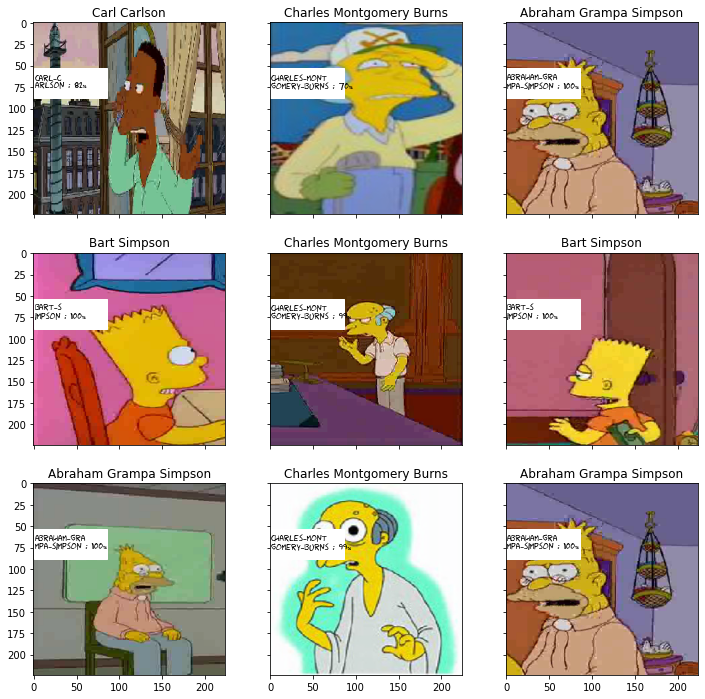

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/MyDrive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
my_submit.to_csv('gdrive/MyDrive/resnet.csv', index=False)

# efficientnet

In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=3412ccc9ac1ba9e51c8a6f936d1944a39e020afed3da3a817c574ec6a917db8d
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [81]:
effnet = models.efficientnet_v2_l(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [82]:
effnet

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [83]:
effnet.classifier = nn.Linear(1280, n_classes)
effnet.cuda()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [84]:
unfr = 5
for param in effnet.features[:-unfr].parameters():
    param.requires_grad = False

In [85]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = optim.Adam(effnet.parameters())
        opt = optim.Adam(list(effnet.features[-unfr:].parameters()) + 
                         list(effnet.classifier.parameters()))
        scheduler = lr_scheduler.StepLR(opt, step_size=2, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            scheduler.step()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [86]:
history = train(train_dataset, val_dataset, model=effnet, epochs=2, batch_size=16)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss 0.7871368275076089


epoch:  50%|█████     | 1/2 [13:36<13:36, 816.01s/it]


Epoch 001 train_loss: 0.7871     val_loss 0.2375 train_acc 0.8011 val_acc 0.9362
loss 0.12585264855370668


epoch: 100%|██████████| 2/2 [27:01<00:00, 810.61s/it]


Epoch 002 train_loss: 0.1259     val_loss 0.1194 train_acc 0.9676 val_acc 0.9717


In [87]:
torch.save(effnet.state_dict(), "/content/gdrive/MyDrive/efficientnetV2.2_weights.pth") 

In [88]:
train(train_dataset, val_dataset, model=effnet, epochs=1, batch_size=16)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

loss 0.40728473050415637


epoch: 100%|██████████| 1/1 [13:28<00:00, 808.07s/it]


Epoch 001 train_loss: 0.4073     val_loss 0.3748 train_acc 0.8965 val_acc 0.8995


[(0.40728473050415637,
  0.8964782480023675,
  0.3747895968446758,
  tensor(0.8995, device='cuda:0', dtype=torch.float64))]

In [89]:
torch.save(effnet.state_dict(), "/content/gdrive/MyDrive/efficientnetV2.3_weights.pth") 

In [90]:
effnet.load_state_dict(torch.load('/content/gdrive/MyDrive/efficientnetV2.2_weights.pth'))

<All keys matched successfully>

In [ ]:
history = train(train_dataset, val_dataset, model=effnet, epochs=2, batch_size=16)

In [ ]:
torch.save(effnet.state_dict(), "/content/gdrive/MyDrive/efficientnetv2_large_weights.pth") 

In [ ]:
effnet.load_state_dict(torch.load('/content/gdrive/MyDrive/efficientnetv2_large_weights.pth'))

In [94]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(effnet, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(effnet, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [95]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)

array([1., 1., 1., 1.])

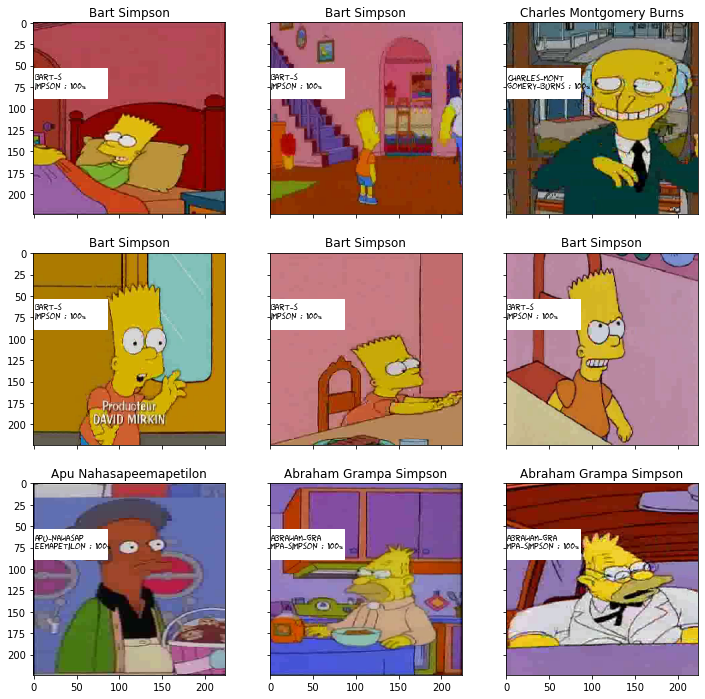

In [97]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(effnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [98]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(effnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [99]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/MyDrive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [101]:
my_submit.to_csv('gdrive/MyDrive/effnet2.csv', index=False)